# Матчинг

## Описание проекта

В рамках проекта вы поработаете с реальными сырыми данными от одного из крупнейших маркетплейсов страны.
Вас ждет интересная задача сопоставления и поиска наиболее похожих товаров.
Сопоставление или “мэтчинг” (англ. matching - соответствия) - одна из базовых задач машинного обучения, которая встречается в информационном поиске, компьютерном зрении, рекомендательных системах и др.

Вы познакомитесь с алгоритмами приближённого поиска ближайщих соседей, научитесь создавать индексы в векторных базах данных и обучать ранжирующие модели. Эти навыки востребованы во многих сферах и позволят вам решать еще более интересные и сложные задачи.


## Imports

In [1]:
import faiss

import pandas as pd
import numpy as np

from sklearn.preprocessing import RobustScaler

In [2]:
k = 5
DATA_PATH = './data/'
faiss.omp_set_num_threads(16)

## Load data

`base.csv` - анонимизированный набор товаров. Каждый товар представлен как уникальный id (0-base, 1-base, 2-base)
 и вектор признаков размерностью 72.

In [3]:
df_base = pd.read_csv(DATA_PATH + "base.csv", index_col=0)
df_base.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-base,-115.083890,11.152912,-64.426760,-118.88089,216.482440,-104.698060,-469.070588,44.348083,120.915344,181.449700,...,-42.808693,38.800827,-151.76218,-74.389090,63.66634,-4.703861,92.933610,115.269190,-112.756640,-60.830353
1-base,-34.562202,13.332763,-69.787610,-166.53348,57.680607,-86.098370,-85.076666,-35.637436,119.718636,195.234190,...,-117.767525,41.100000,-157.82940,-94.446806,68.20211,24.346846,179.937930,116.834000,-84.888941,-59.524610
2-base,-54.233746,6.379371,-29.210136,-133.41383,150.895830,-99.435326,52.554795,62.381706,128.951450,164.381470,...,-76.397800,46.011803,-207.14442,127.325570,65.56618,66.325680,81.073490,116.594154,-1074.464888,-32.527206
3-base,-87.520130,4.037884,-87.803030,-185.06763,76.369540,-58.985165,-383.182845,-33.611237,122.031910,136.233580,...,-70.647940,-6.358921,-147.20105,-37.692750,66.20289,-20.566910,137.206940,117.474100,-1074.464888,-72.915490
4-base,-72.743850,6.522049,43.671265,-140.60803,5.820023,-112.074080,-397.711282,45.182500,122.167180,112.119064,...,-57.199104,56.642403,-159.35184,85.944724,66.76632,-2.505783,65.315285,135.051590,-1074.464888,0.319401


In [4]:
df_base.shape

(2918139, 72)

`train.csv` - обучающий датасет. Каждая строчка - один товар, для которого известен уникальный id (0-query, 1-query, …),
 вектор признаков И id товара из base.csv, который максимально похож на него (по мнению экспертов).

In [5]:
df_train = pd.read_csv(DATA_PATH + "train.csv", index_col=0)
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,Target
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572,675816-base
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833,366656-base
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178,1447819-base
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788,1472602-base
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351,717819-base


`validation.csv` - датасет с товарами (уникальный id и вектор признаков), для которых надо найти наиболее близкие товары из `base.csv`

`validation_answer.csv` - правильные ответы к предыдущему файлу.

## Base

### Base dataset

### Create index

In [6]:
dims = df_base.shape[1]
n_cells = 10
# how many cells
quantizer = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [7]:
idx_l2.train(np.ascontiguousarray(df_base.values[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base.values).astype('float32'))

In [8]:
base_index = {k: v for k, v in enumerate(df_base.index.to_list())}
#del df_base

## First model

In [9]:
targets = df_train["Target"]
df_train.drop("Target", axis=1, inplace=True)

In [10]:
def accuracy_5(_df: pd.DataFrame, _targets: pd.Series, _idx, _base_index, _k: int) -> float:
    '''расчет '''
    if type(_df) == np.ndarray:
        vecs, idx = _idx.search(np.ascontiguousarray(_df).astype('float32'), _k)
    elif type(_df) == pd.DataFrame:
        vecs, idx = _idx.search(np.ascontiguousarray(_df.values).astype('float32'), _k)
    else:
        raise TypeError #'Ожидался тип данных pd.DataFrame или np.ndarray'
    acc = 0
    for target, el in zip(_targets.values.tolist(), idx.tolist()):
        acc += int(target in [_base_index[r] for r in el])
    
    return 100 * acc / len(idx)

In [11]:
accuracy_5(df_train, targets, idx_l2, base_index, k)

12.623

## EDA

In [12]:
df_samples = df_train#[:5000]

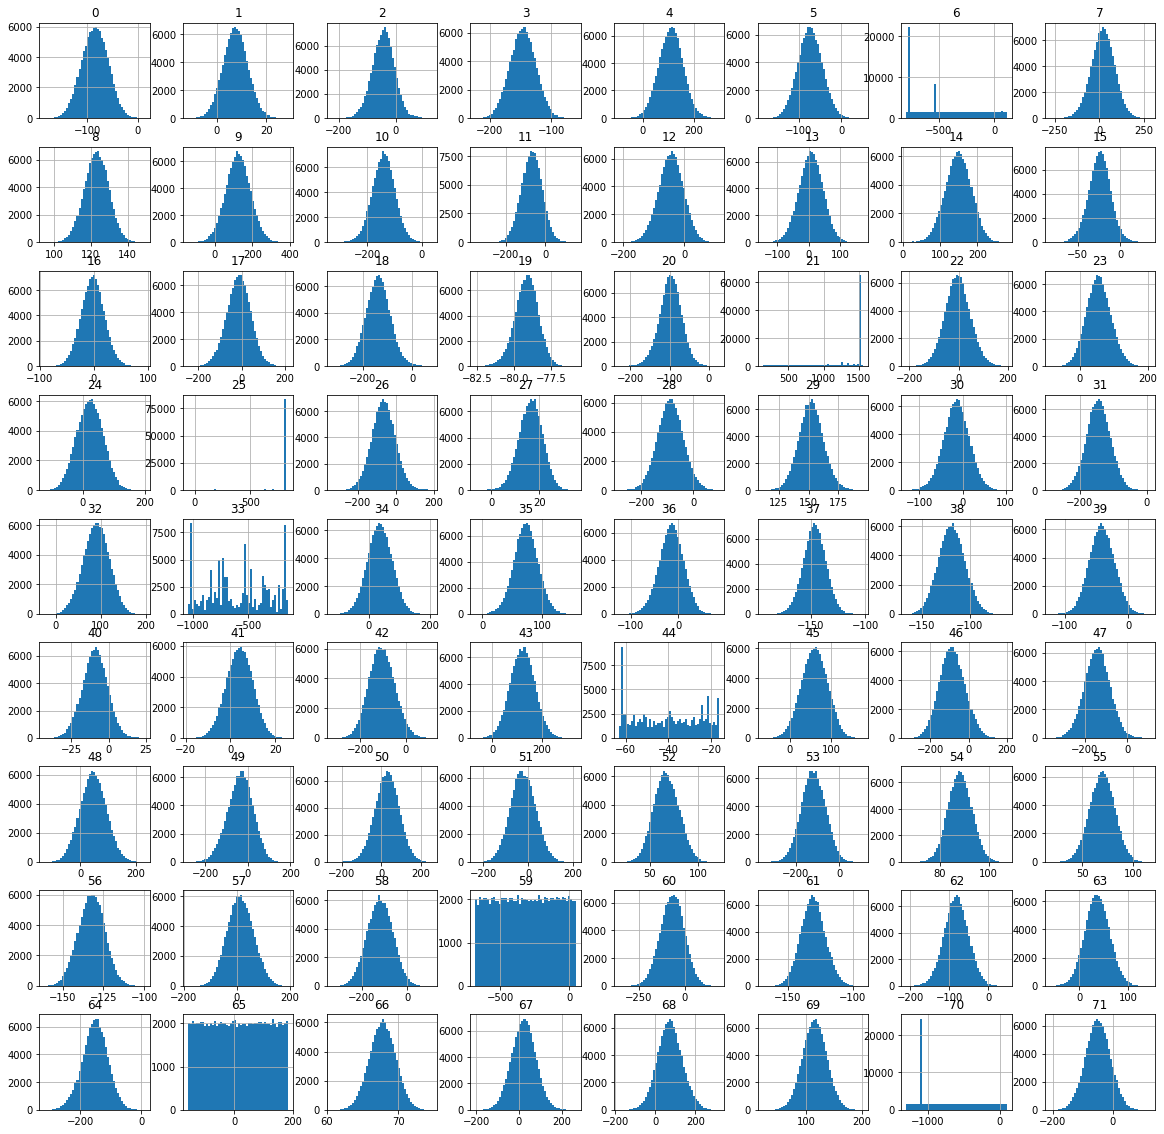

In [13]:
df_samples.hist(figsize=[20, 20], bins=50);

### Рассмотрим по подробнее признаки, которые имеют не нормальное распределение

#### 6

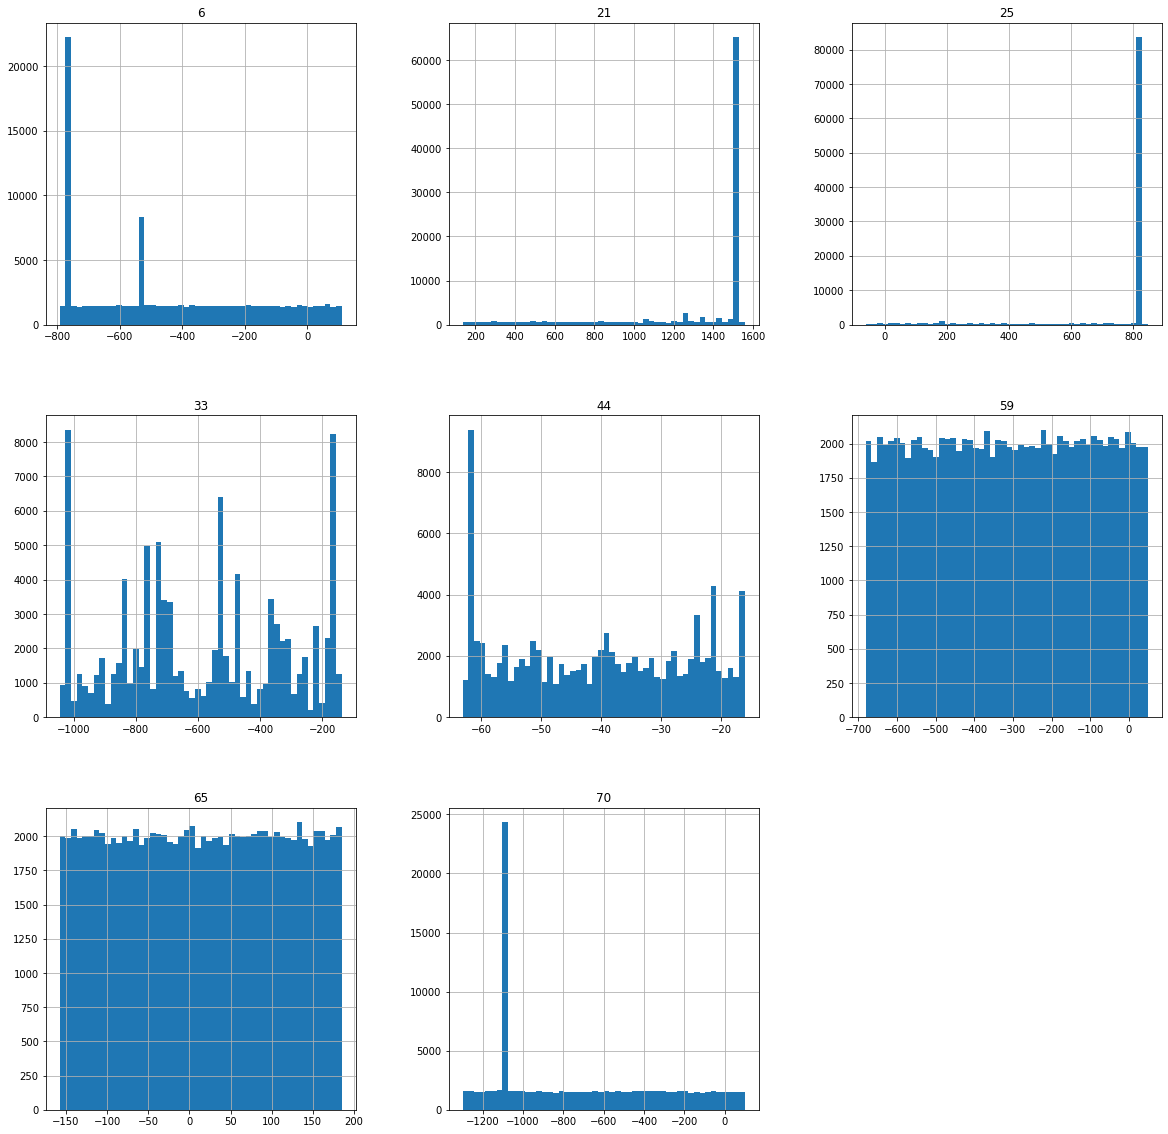

In [83]:
df_samples[['6', '21', '25', '33', '44', '59', '65', '70']].hist(figsize=[20, 20], bins=50)
None

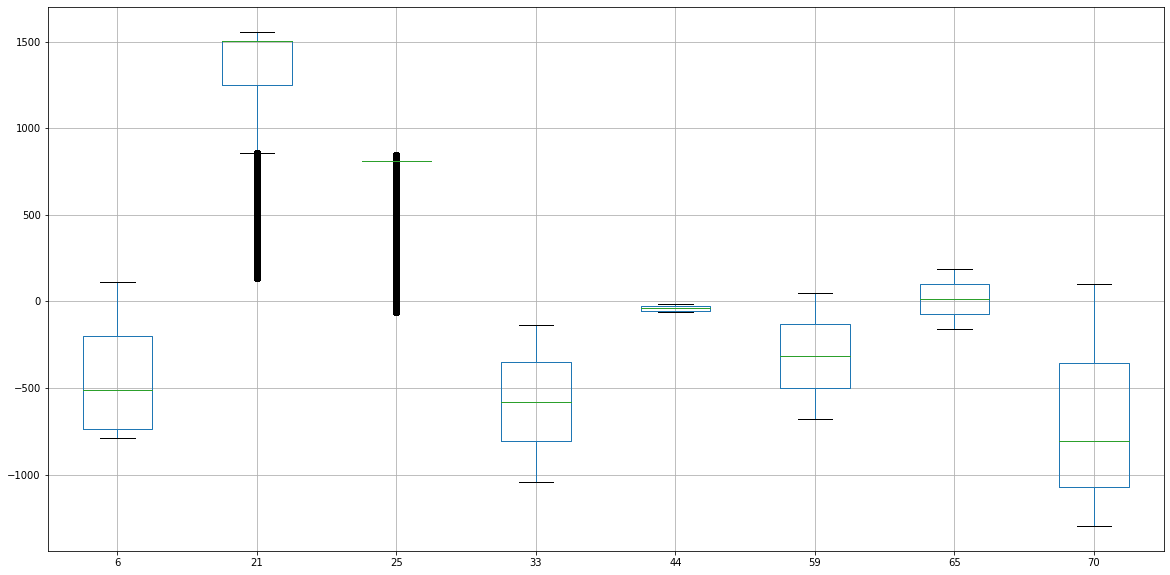

In [91]:
df_samples.boxplot(column=['6', '21', '25', '33', '44', '59', '65', '70'], figsize=[20, 10])
None

### Взаимная кореляция выбранных признаков

In [33]:
df_samples['21'].corr(df_samples['25'])

0.05947941667101121

In [34]:
df_samples['59'].corr(df_samples['65'])

0.0025634083999757917

### Нормализация данных

In [35]:
scaler = RobustScaler()

In [36]:
df_base2 = scaler.fit_transform(df_base)

In [37]:
df_train2 = scaler.transform(df_train)

In [38]:
dims = df_base2.shape[1]
n_cells = 10
# how many cells
quantizer2 = faiss.IndexFlatL2(dims)
idx_l2 = faiss.IndexIVFFlat(quantizer, dims, n_cells)

In [39]:
idx_l2.train(np.ascontiguousarray(df_base2[:50000, :]).astype('float32'))
idx_l2.add(np.ascontiguousarray(df_base2).astype('float32'))

In [40]:
accuracy_5(df_train2, targets, idx_l2, base_index, k)

53.825

После нормализации признаков, получилось добиться увеличения качества в 4.4 раза

## Удаление признаков

Посчитаем корреляцию

In [92]:
df_train.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,-68.770600,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351


In [108]:
corr1 = df_train.iloc[:500]
corr1.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
0-query,-53.882748,17.971436,-42.117104,-183.93668,187.517490,-87.144930,-347.360606,38.307602,109.085560,30.413513,...,-105.427820,70.107360,-155.80257,-101.965943,65.903790,34.457500,62.642094,134.763600,-415.750254,-25.958572
1-query,-87.776370,6.806268,-32.054546,-177.26039,120.803330,-83.810590,-94.572749,-78.433090,124.915900,140.331070,...,-40.812233,4.669178,-151.69771,-1.638704,68.170876,25.096191,89.974976,130.589630,-1035.092211,-51.276833
2-query,-49.979565,3.841486,-116.118590,-180.40198,190.128430,-50.837620,26.943937,-30.447489,125.771164,211.607820,...,-52.031662,78.039764,-169.14620,82.144186,66.008220,18.400496,212.409730,121.931470,-1074.464888,-22.547178
3-query,-47.810562,9.086598,-115.401695,-121.01136,94.652840,-109.255410,-775.150134,79.186520,124.003100,242.650650,...,-61.567047,44.515266,-145.41675,93.990981,64.131350,106.061920,83.178760,118.277725,-1074.464888,-19.902788
4-query,-79.632126,14.442886,-58.903397,-147.05254,57.127068,-16.239529,-321.317964,45.984676,125.941284,103.392670,...,-68.770600,45.028910,-196.09207,-117.626337,66.926220,42.456170,77.621765,92.479930,-1074.464888,-21.149351


In [109]:
corr2 = df_base.loc[targets[:500].values.tolist()]
corr2.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
675816-base,-63.856552,17.163416,-32.269220,-169.75210,198.870730,-77.228960,-347.360606,13.288679,108.231070,43.82885,...,-107.259094,80.318184,-151.78957,56.448963,66.886116,45.391710,40.096794,116.982010,-415.750254,-18.195980
366656-base,-88.614190,4.574929,-22.700304,-144.94324,80.877815,-92.111590,-530.528109,-18.696142,114.099470,163.91055,...,-77.159775,12.424929,-162.74518,85.860939,70.269700,-15.091993,48.642250,101.123980,-1074.464888,-71.665270
1447819-base,-68.748230,3.549367,-126.559456,-169.50517,195.694610,-52.882294,26.943937,-23.964437,119.211330,227.63394,...,-51.152130,94.640840,-176.32103,119.981731,66.266970,17.248710,170.587340,131.261600,-1074.464888,-33.020058
1472602-base,-50.560276,6.856050,-116.298416,-134.44357,65.365280,-127.862350,-775.150134,93.207756,125.221085,269.04950,...,-56.015300,41.230500,-136.19551,7.052096,64.016380,97.340790,54.679436,118.847440,-903.069010,3.276848
717819-base,-79.635185,14.442431,-58.904266,-147.05140,57.131943,-16.240410,-321.317964,45.992638,125.942150,103.38858,...,-68.775360,45.028675,-196.09872,-117.626337,66.926575,42.453735,77.619740,92.482574,-1074.464888,-21.129560


In [112]:
t = pd.DataFrame.from_dict({col_id: np.corrcoef(corr1.iloc[:, col_id], corr2.iloc[:, col_id])[0, 1] for col_id in range(0, 72) }, orient="index").sort_values(0, ascending=False)#[-10:]

In [113]:
t[-20:]

,0
19,0.822287
27,0.818466
29,0.815522
47,0.812317
42,0.812190
45,0.810561
8,0.808537
18,0.804391
62,0.801383
40,0.801156


In [114]:
df_samples.corr()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
0,1.000000,0.005141,0.002172,-0.012514,-0.019630,-0.010645,0.009241,-0.010087,-0.009149,0.000220,...,0.002459,-0.026126,-0.009391,-0.001189,-0.010962,-0.003895,-0.009693,-0.027023,-0.016043,-0.017728
1,0.005141,1.000000,-0.008741,0.005383,-0.000338,-0.008188,0.011282,0.010787,-0.001937,-0.000510,...,-0.005167,-0.003761,-0.021873,-0.004735,0.008024,-0.007563,-0.011825,0.016123,-0.014883,0.020817
2,0.002172,-0.008741,1.000000,-0.014821,-0.017966,0.005171,-0.007881,-0.018625,0.020178,0.016323,...,-0.028888,-0.008702,0.001787,-0.002327,-0.026570,-0.010198,-0.019652,0.002814,0.005712,0.004332
3,-0.012514,0.005383,-0.014821,1.000000,0.009271,-0.007097,-0.004944,0.006825,0.004244,0.033505,...,0.002490,-0.024133,-0.008766,-0.001255,0.012300,0.004461,0.026721,-0.003116,0.005844,0.014606
4,-0.019630,-0.000338,-0.017966,0.009271,1.000000,-0.006796,0.020441,-0.007682,-0.013266,0.016618,...,0.009002,-0.002062,-0.001907,0.002237,-0.003915,-0.011723,-0.005744,-0.012335,0.000445,-0.008475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67,-0.003895,-0.007563,-0.010198,0.004461,-0.011723,0.005113,0.006253,0.013951,-0.003560,-0.008335,...,-0.008937,-0.012067,-0.013836,0.001379,0.008174,1.000000,-0.001822,0.019531,-0.018206,0.012929
68,-0.009693,-0.011825,-0.019652,0.026721,-0.005744,0.033893,0.030402,-0.000804,-0.004044,0.005433,...,0.014377,0.020137,-0.010439,-0.008322,0.037986,-0.001822,1.000000,0.027631,-0.009601,0.025308
69,-0.027023,0.016123,0.002814,-0.003116,-0.012335,0.012586,0.003302,-0.000387,-0.004830,-0.022047,...,0.031987,0.017890,-0.009967,-0.003588,-0.014929,0.019531,0.027631,1.000000,0.007226,-0.002488
70,-0.016043,-0.014883,0.005712,0.005844,0.000445,0.026322,-0.039151,0.001945,-0.024537,0.014237,...,-0.018332,-0.005062,0.025831,-0.002886,0.013508,-0.018206,-0.009601,0.007226,1.000000,0.011014


## Drop 1

Удалим столбцы из набора данных, распределение которых не соответствует нормальному распределению данных

In [46]:
DROP_COLS = [str(el) for el in [6, 21, 25, 33, 44, 59, 65, 70]]

In [47]:
rs = RobustScaler() 
df_base3 = rs.fit_transform(df_base.drop(columns=DROP_COLS))

df_train3 = rs.transform(df_train.drop(columns=DROP_COLS))

dims = df_base3.shape[1]
n_cells = 10
# how many cells
quantizer3 = faiss.IndexFlatL2(dims)
idx_l3 = faiss.IndexIVFFlat(quantizer3, dims, n_cells)

idx_l3.train(np.ascontiguousarray(df_base3[:50000, :]).astype('float32'))
idx_l3.add(np.ascontiguousarray(df_base3).astype('float32'))

In [48]:
accuracy_5(df_train3, targets, idx_l3, base_index, k)

63.463

In [49]:
accuracy_5(df_train3, targets, idx_l3, base_index, 100)

69.229

In [50]:
accuracy_5(df_train3, targets, idx_l3, base_index, 1000)

71.765

In [58]:
df_test = pd.read_csv(DATA_PATH + "validation.csv", index_col=0)
df_test.head()

,0,1,2,3,4,5,6,7,8,9,...,62,63,64,65,66,67,68,69,70,71
Id,,,,,,,,,,,,,,,,,,,,,
100000-query,-57.372734,3.597752,-13.213642,-125.92679,110.74594,-81.279594,-461.003172,139.815720,112.880980,75.215750,...,-75.51302,52.830902,-143.43945,59.051935,69.28224,61.927513,111.59253,115.140656,-1099.130485,-117.079360
100001-query,-53.758705,12.790300,-43.268543,-134.41762,114.44991,-90.520130,-759.626065,63.995087,127.117905,53.128998,...,-79.44183,29.185436,-168.60590,-82.872443,70.76560,-65.975950,97.07716,123.391640,-744.442332,-25.009320
100002-query,-64.175095,-3.980927,-7.679249,-170.16093,96.44616,-62.377740,-759.626065,87.477554,131.270110,168.920320,...,-134.79541,37.368730,-159.66231,-119.232725,67.71044,86.002060,137.63641,141.081630,-294.052271,-70.969604
100003-query,-99.286860,16.123936,9.837166,-148.06044,83.69708,-133.729720,58.576403,-19.046660,115.042404,75.206730,...,-77.23611,44.100494,-132.53012,-106.318982,70.88396,23.577892,133.18396,143.252940,-799.363667,-89.392670
100004-query,-79.532920,-0.364173,-16.027431,-170.88495,165.45392,-28.291668,33.931936,34.411217,128.903980,102.086914,...,-123.77025,45.635944,-134.25893,13.735359,70.61763,15.332115,154.56812,101.700640,-1171.892332,-125.307890


In [59]:
df_test.drop(columns=DROP_COLS, inplace=True)

In [60]:
arr_test = rs.transform(df_test)

# Erf function

In [61]:
from scipy.special import erf

In [62]:
rs = RobustScaler() 
df_base4 = erf(rs.fit_transform(df_base.drop(columns=DROP_COLS)))
df_train4 = erf(rs.transform(df_train.drop(columns=DROP_COLS)))

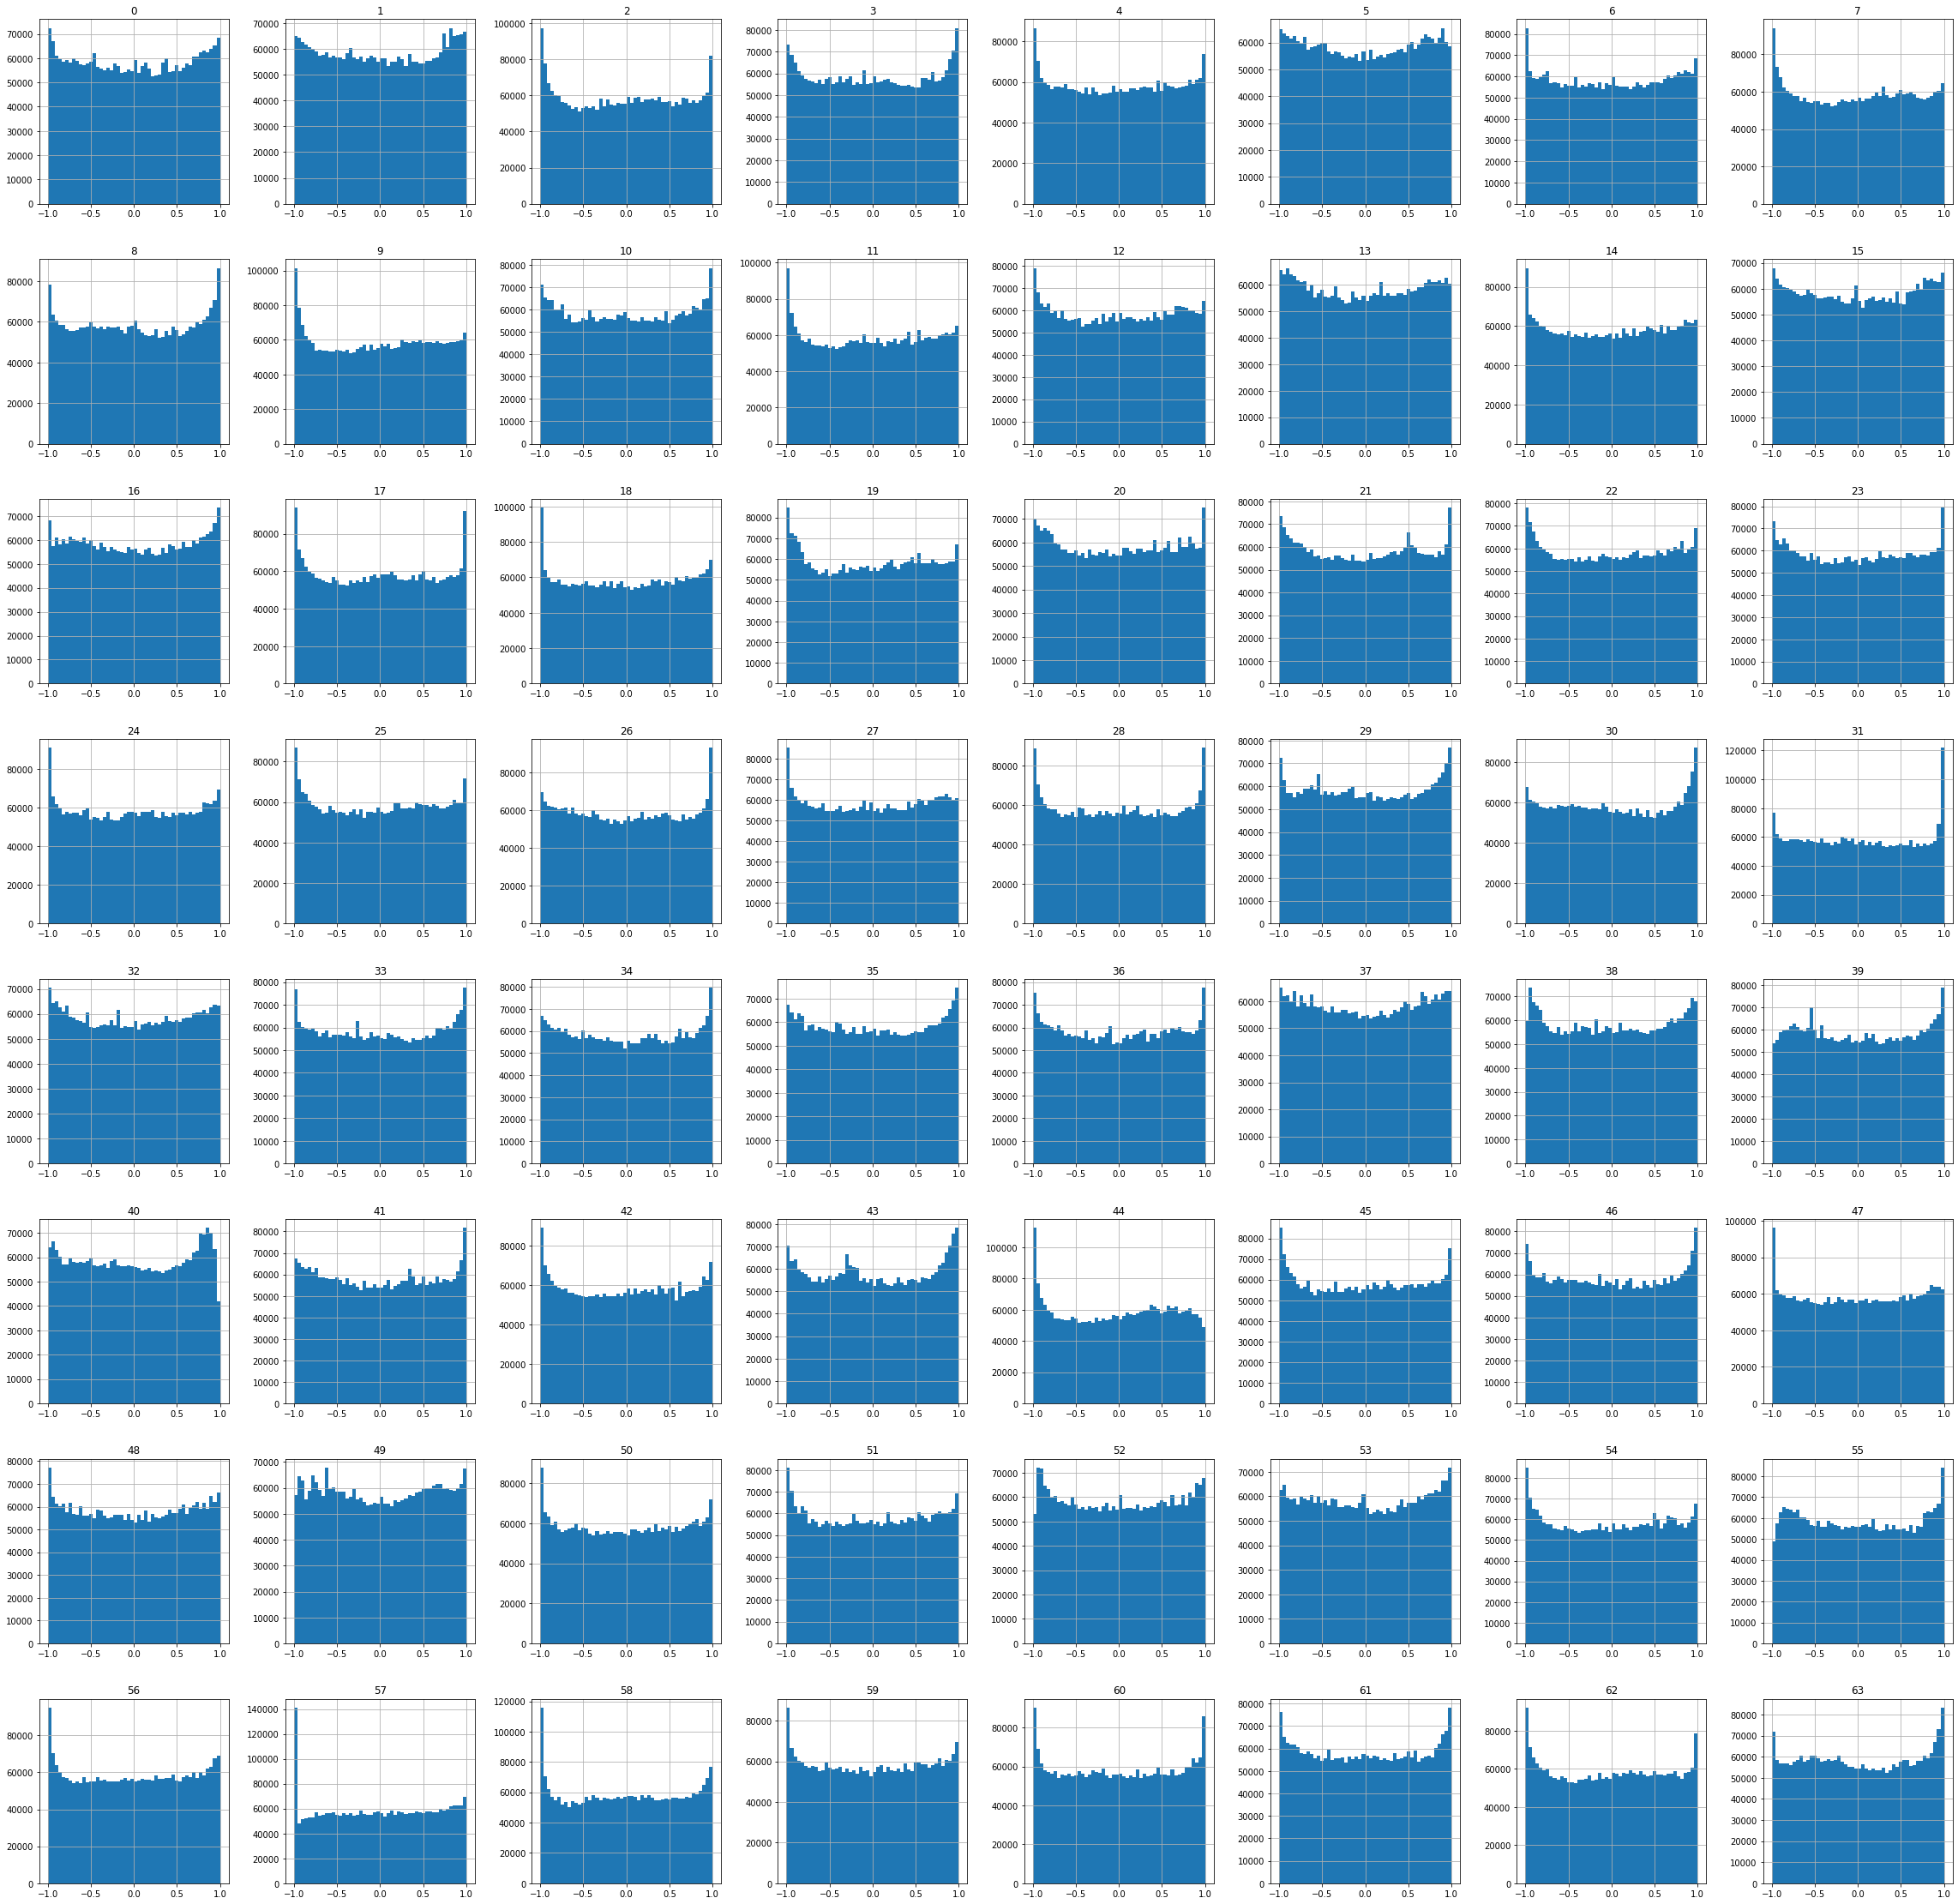

In [97]:
pd.DataFrame(df_base4).hist(bins=50, figsize=(40, 40));

In [64]:
dims = df_base4.shape[1]
n_cells = 10
# how many cells
quantizer4 = faiss.IndexFlatL2(dims)
idx_l4 = faiss.IndexIVFFlat(quantizer4, dims, n_cells)

idx_l4.train(np.ascontiguousarray(df_base4[:50000, :]).astype('float32'))
idx_l4.add(np.ascontiguousarray(df_base4).astype('float32'))

In [65]:
accuracy_5(df_train4, targets, idx_l4, base_index, k)

62.847

In [66]:
accuracy_5(df_train4, targets, idx_l4, base_index, 100)

68.538

In [67]:
accuracy_5(df_train4, targets, idx_l4, base_index, 1000)

71.122

In [68]:
accuracy_5(df_train4, targets, idx_l4, base_index, 10000)

72.624

# Pipeline

In [69]:
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

In [70]:
class DropColumns(TransformerMixin):
    
    def __init__(self, columns=[]):
        self._cols = columns
        
    def fit(self, x, y=None):
        return self
    
    def transform(self, x: pd.DataFrame, y=None):
        return x.drop(columns=self._cols, )

In [71]:
class FaissIndex:
    
    def __init__(self, pipeline=None, n_clusters=10):
        self._base_idx = {}
        self._pipeline = pipeline
        self.d = None
        self.n_clusters = n_clusters
        self._idx = None
        self._base_idx = {}
        
    def build_index(self, df: pd.DataFrame):
        arr = self._pipeline.fit_transform(df)
        
        self._base_idx = {k: v for k, v in enumerate(df.index.to_list())}        
        self.d = arr.shape[1]
        
        quantizer = faiss.IndexFlatL2(self.d)
        self._idx = faiss.IndexIVFFlat(quantizer, self.d, self.n_clusters)
        
        n_train_samples = 50000
        print("Train. Number of train samples is ", n_train_samples)
        arr_train = arr[np.random.randint(arr.shape[0], size=n_train_samples)]
        self._idx.train(np.ascontiguousarray(arr_train).astype('float32'))

        print("Update index")
        self._idx.add(np.ascontiguousarray(arr).astype('float32'))
        
    def get(self, df, n=5):
        arr = self._pipeline.transform(df)
        vecs, idx = self._idx.search(np.ascontiguousarray(arr).astype('float32'), n)
        
        res = []
        for el1 in idx:
            res.append([self._base_idx[el2] for el2 in el1])
        
        return res

In [72]:
pipe1 = Pipeline([("drop", DropColumns(columns=["33"])),
                  ("scaler", MinMaxScaler())])

f = FaissIndex(pipeline=pipe1)

f.build_index(df_base)

Train. Number of train samples is  50000
Update index


In [73]:
f.get(df_train)

[['3536676-base',
  '461614-base',
  '2391444-base',
  '681341-base',
  '4613063-base'],
 ['1075687-base',
  '854272-base',
  '318299-base',
  '1731665-base',
  '3151891-base'],
 ['2238236-base',
  '1800619-base',
  '3677306-base',
  '729716-base',
  '1792316-base'],
 ['1472602-base',
  '1404644-base',
  '3705576-base',
  '171668-base',
  '850013-base'],
 ['717819-base',
  '1663474-base',
  '2335569-base',
  '584999-base',
  '3418633-base'],
 ['2381316-base', '48081-base', '3230945-base', '51473-base', '4110612-base'],
 ['4729242-base',
  '1503525-base',
  '1830480-base',
  '665381-base',
  '714118-base'],
 ['1177142-base', '811725-base', '22409-base', '61396-base', '3551678-base'],
 ['106461-base', '371867-base', '1909576-base', '3847994-base', '113017-base'],
 ['3838039-base',
  '1313418-base',
  '786555-base',
  '2532443-base',
  '3548851-base'],
 ['1790410-base', '266030-base', '421922-base', '258545-base', '1860476-base'],
 ['955302-base', '711605-base', '1081061-base', '876561-ba